<a href="https://colab.research.google.com/github/DoclDai/MPC_OptimalControl_Code/blob/main/MPC_Optimal_Control_Code_Zaowei_Dai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Please run this cell only if you are using Google Colab.

# install required dependencies
# import sys
# IN_COLAB = 'google.colab' in sys.modules
# if IN_COLAB:

!pip install -q pyomo
!apt-get install -y -qq glpk-utils
!apt-get install -y -qq coinor-cbc
!wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
!unzip -o -q ipopt-linux64
!pip install polytope


------

In [ ]:
import polytope as pt
import numpy as np
import matplotlib.pyplot as plt
import scipy

def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        # assuming vertices are in (N x d) shape. N # of vertices, d dimension
        V1 = X

    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
    return pt.qhull(np.asarray(V_sum))

def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([])):
        if not B.any():
            return pt.Polytope(Xset.A @ A, Xset.b)
        else:
            tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)

def Oinf(Xset, A, Wset=pt.Polytope()):
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = pt.reduce(precursor(Omega, A, Wset=Wset).intersect(Omega))
        else:
            Omegap = pt.reduce(precursor(Omega, A).intersect(Omega))
    return Omegap


------

We define the parameters here

In [ ]:
#Scene parameters
l_car   = 4.5  # m
d_stop = 100

#CFTOC parameters
nz      = 2       # number of states
nu      = 1       # number of inputs
Ts      = 1       #s
N       = 3       #Horizon
v_max   = 32      #m/s
g       = 9.81    #m/s^2

#Initial condition
zbar0 = np.array([0,20]).T #Initial condition

#Cost matrices
Q = np.array([[0,0],[0,1]])
R = 1

In [ ]:
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition

#Example of extracting the termination_condition of the solver:
example_model = pyo.ConcreteModel()
example_model.x = pyo.Var()
example_model.obj = pyo.Objective(expr=example_model.x)
example_model.const = pyo.Constraint(expr = example_model.x >= 0)
example_results = pyo.SolverFactory('cbc').solve(example_model)

example_termination_condition = example_results.solver.termination_condition

print(f'The solver termination condition: {example_termination_condition}')
print(f'Is termination_condition == optimal? {example_termination_condition==TerminationCondition.optimal}') #Terminating optimally means the problem is feasible!

The solver termination condition: optimal
Is termination_condition == optimal? True


# <font color='red'>DELIVERABLES:</font>

<font color='red'>D1:</font> Write a **function** `cftoc`, which solves the CFTOC (3) using *Pyomo*, with function declaration line

` def cftoc(zbar0, d_stop, N, P, Af = np.nan, bf=np.nan): return zOpt, uOpt, is_optimal`

 where the input` zbar0` is the initial state of the vehicle and `d0` is the initial distance to the intersection. P is the terminal cost matrix. Af and bf represent the terminal constraint set where $X_f = \{x\in \mathbb{R}^2|A_f x \leq b_f\}$. The function should have three outputs. zOpt and uOpt are optimizers each representing $(z_0^*,...,z_N^*)$ and $(u_0^*,...,u_{N-1}^*)$, respectively. Lastly, is_optimal is a binary variable representing the optimality of the solver's termination condition.




**Submit the result of the provided unit test**

In [ ]:
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition
from pyomo.environ import inequality

def cftoc(zbar0, d_stop, N, P, Af = np.nan, bf=np.nan):
    model = pyo.ConcreteModel()
    model.N = N

    # Indices for decision variables
    model.nx = 2

    # Decision variables for states and inputs
    model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )
    model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )

    model.z = pyo.Var(model.xIDX, model.tIDX)
    model.u = pyo.Var(model.tIDX)

    # Parameters for the vehicle model
    A = np.array([[1, 1], [0, 1]])  # State transition matrix
    B = np.array([[0], [1]])  # Control input matrix

    model.A = A
    model.B = B
    model.Q = Q
    model.P = P
    model.R = R
    model.Af = Af
    model.bf = bf

    # Objective function
    def objective_rule(model):
        costZ = 0.0
        costU = 0.0
        costTerminal = 0.0
        for t in model.tIDX:
            for i in model.xIDX:
                for j in model.xIDX:
                    if t < model.N:
                        costZ += (model.z[i, t] - zbar0[i]) * model.Q[i, j] * (model.z[j, t] - zbar0[i])
        for t in model.tIDX:
                    if t < model.N:
                        costU += model.u[t] ** 2
        for i in model.xIDX:
            for j in model.xIDX:
                costTerminal += (model.z[i, N] - zbar0[i]) * model.P[i, j] * (model.z[j, N] - zbar0[i])

        return costZ + costU + costTerminal

    model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

    def equality_const_rule(model, i, t):
        if t == N:
            return pyo.Constraint.Skip

        else:
            return model.z[i, t+1] == sum(model.A[i, j] * model.z[j, t] for j in model.xIDX) +  model.B[i, 0] * model.u[t]

    model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)

    model.init_const1 = pyo.Constraint(expr = model.z[0, 0] == zbar0[0])
    model.init_const2 = pyo.Constraint(expr = model.z[1, 0] == zbar0[1])

    def u_constraint_rule(model, t):
           return inequality(-g/2, model.u[t], g/2)

    model.u_constraint = pyo.Constraint(model.tIDX, rule=u_constraint_rule)

    def z_constraint1_rule(model, t):
           return inequality(0, model.z[0, t], d_stop - l_car/2)

    model.z_constraint1 = pyo.Constraint(model.tIDX, rule=z_constraint1_rule)

    def z_constraint2_rule(model, t):
           return inequality(0, model.z[1, t], v_max)

    model.z_constraint2 = pyo.Constraint(model.tIDX, rule=z_constraint2_rule)

    Af = None if np.isnan(Af).all() else Af
    bf = None if np.isnan(bf).all() else bf

    if Af is not None and bf is not None:

      Af = np.array(Af)
      bf = np.array(bf)

      def terminal_set_rule(model, i):

         return sum(Af[i, j] * model.z[j, model.N] for j in range(len(zbar0))) <= bf[i]

      model.terminal_set_constraints = pyo.Constraint(range(len(bf)), rule=terminal_set_rule)
    else:

       pass

    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(model)

    is_optimal = results.solver.termination_condition == TerminationCondition.optimal

    zOpt = np.asarray([[model.z[i,t]() for i in model.xIDX] for t in model.tIDX]).T
    uOpt = np.asarray([model.u[t]() for t in model.tIDX]).T

    JOpt = model.cost()

    return zOpt, uOpt, results.solver.termination_condition=='optimal'

The function ` def sim_mpc(zbar0,d_stop,N,Af,bf,P): return zOpt ` defined below executes a closed-loop MPC simulation for $M = 100$ steps. This function will **plot the closed-loop trajectories as well as open-loop predictions** if the MPC is recursively feasible. **If not recursively feasible, it will not plot anything and print out a Pyomo infeasibility warning.** Note that inside this function, we are calling `cftoc(zbar0, d_stop, N, P, Af = np.nan, bf=np.nan)` as defined above. The output of the function returns the optimizers $(z_0^*,...,z_N^*)$


In [ ]:
def sim_mpc(z0,d_stop,N,Af,bf,P):
  #Simulation time
  M = 100

  #### Initialize ###
  zOpt = np.zeros((nz, M+1))
  uOpt = np.zeros((nu, M))
  zOpt[:, 0] = z0.reshape(nz, )
  feas = np.zeros((M, ), dtype=bool)
  zN = np.zeros((nz,1))
  infeas_flag = False
  ###################

  fig = plt.figure(figsize=(9, 6))

  #MPC Closed-loop simulation
  for time in range(M):

      [z, a, feas[time]] = cftoc(zOpt[:, time],d_stop,N,P,Af,bf)

      if not feas[time]:
          zOpt = []
          uOpt = []
          infeas_flag = True
          break
      # Save closed loop trajectory
      # Note that the second column of x represents the optimal closed loop state
      zOpt[:, time+1] = z[:,1]
      uOpt[:, time] = a[0]

      # Plot Open Loop
      line1 = plt.plot(z[0,:], z[1,:], 'b--')

  #Print/plot results
  if infeas_flag:
    print(feas) #You may see a plot with some openloop trajectories even when the MPC is not recursively feasible. Ignore this figure.
  else:
    print(feas)
    # Plot Closed Loop and Openloop trajectories
    line2 = plt.plot(zOpt[0, :], zOpt[1, :], 'go-')
    plt.legend([line1[0], line2[0]], ['Open-loop', 'Closed-loop']);
    plt.axvline(x=100, ymin=-100, ymax=100, c = 'r')
    plt.xlabel('d (m)')
    plt.ylabel('v (m/s)')
    plt.ylim([0,50])
    plt.axis('equal')

  return zOpt


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


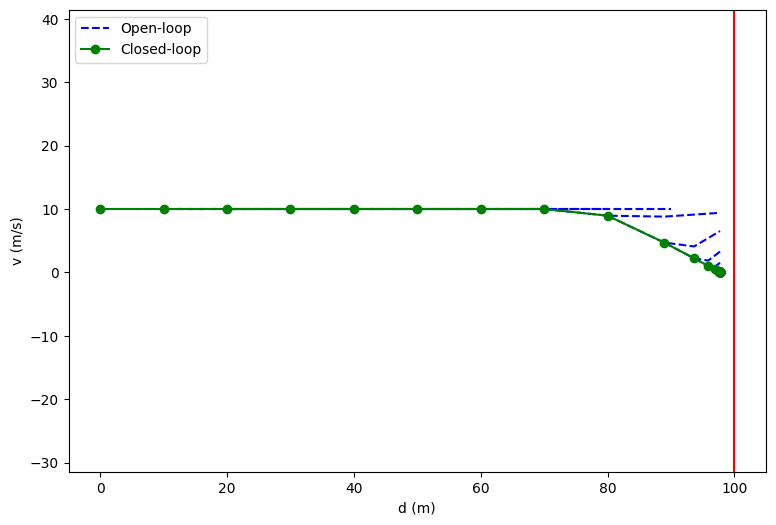

In [ ]:
# Unit test (Submit the results of this unit test in your write-up)
_ = sim_mpc(np.array([0,10]),d_stop,N,np.nan,np.nan,P=Q)

<font color='red'>D2:</font> Use $\bar{z}_{0}=[0,20]^{\top}$ and $d_{stop}=100$ m. Call the `sim_mpc()` function from (D1) with the given inputs `zbar0`=$\bar{z}_0$, `d_stop`=$d_{stop}$, $P = Q$, $N=3$ to determine recursive feasibility and plot closed-loop trajectories with open-loop predictions.. Do not impose any terminal constraints here (i.e. $A_f=b_f=np.nan$).

* Submit the results of the sim\_mpc() function for the given conditions, including a plot of open-loop predictions and closed-loop trajectories.
* Is the MPC that you designed recursively feasible using the given settings and initial condition during the simulation time $M=100$? Explain why or why not (Only stating that the MPC is feasible for n-steps or no longer feasible after k-steps is not an acceptable answer. Please explain why this happens).
* In case the MPC is not recursively feasible for a particular initial condition, could increasing $N$ make it recursively feasible from the same initial condition? Explain the pros and cons of this approach.  


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


[ True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


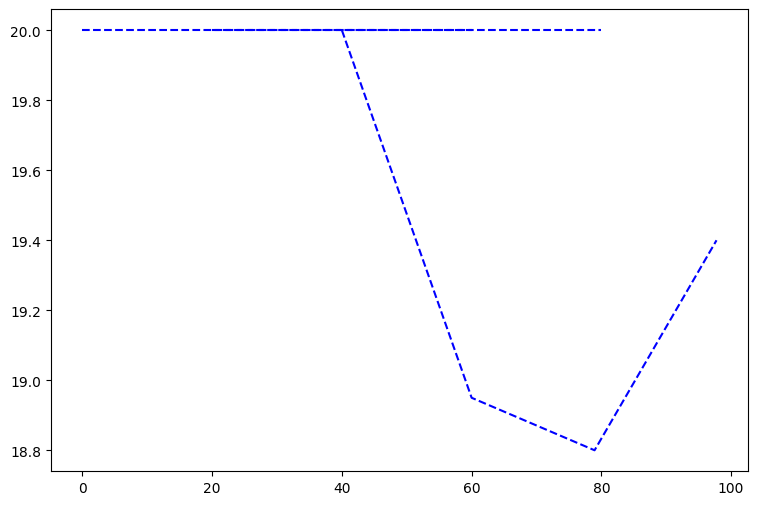

In [ ]:
_ = sim_mpc(zbar0,d_stop,3,np.nan,np.nan,P=Q)

The MPC I designed is not recursive feasible after 3nd steps. Reasons are as follow:

1.Prediction horizon length N is just 3, which is too short that it may not capture the necessary future behavior of the system to find a feasible solution.

2.The initial condition zbar0 is not in the feasible set under N = 3, which means that initial conditions or control inputs may result in the system evolving to a state where no further control inputs can satisfy the constraints.

3.Strict State Constraints: The state constraints might be too restrictive given the system's dynamics and the initial state. For example, if the vehicle's speed is too high and the stopping distance (d_stop) does not allow for a feasible deceleration within the speed and acceleration constraints, the problem will become infeasible.

4.Strcit Control Constraints: The control inputs required to achieve the desired state within the horizon might exceed the control limits (u_max, u_min).

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


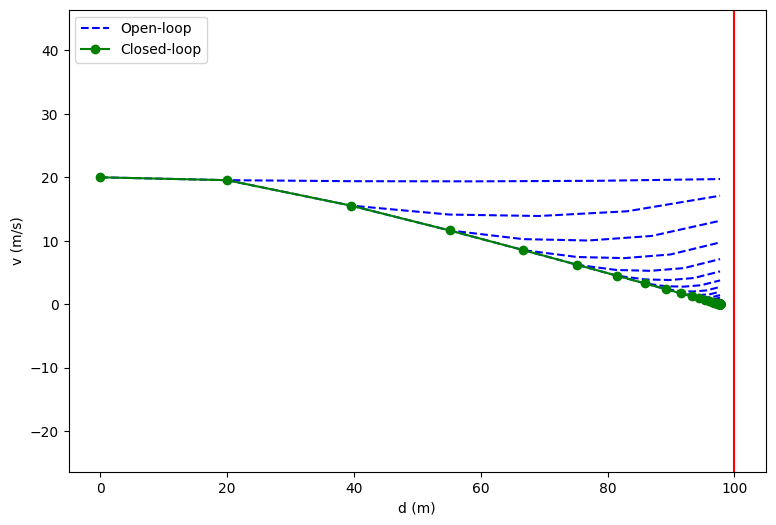

In [ ]:
_ = sim_mpc(zbar0,d_stop,5,np.nan,np.nan,P=Q)

 I increased N from 5 and found that increasing N makes it recursively feasible from the same initial condition.

 Pros:

 1.Improved Feasibility: A longer horizon allows the MPC to "see" further into the future, which can help in planning a feasible trajectory from the current state to the desired final state. If the horizon is too short, the optimization may not be able to find a feasible path that satisfies all the constraints.

 2.Smoother Control Actions: With a longer horizon, the controller can make more informed decisions that lead to smoother control actions, as it can better anticipate future events and consider more constraints.

 3.Higher probability of stability: A longer horizon can help stabilize the closed-loop system by optimizing over a larger set of future states and inputs, which can align more with infinite-horizon optimal control, where stability is more likely to be ensured.

 Cons:

 1.Bigger computation pressure: A longer prediction horizon significantly increases the computational burden because the optimization problem becomes larger and more complex, leading to longer solve times which can be problematic for real-time control.

 2.Increased difficulty in solving optimization problems: A longer horizon means more variables and potentially more complex constraint handling within the optimization problem, which can make the problem more difficult to solve.

 3.Increased difficulty in application: In real-time systems, the increased computational demand may lead to delays that can negate the benefits of a longer horizon, especially if the system dynamics or the environment changes rapidly.

------

<font color='red'>D3:</font> Use $\bar{z}_{0}=[0,20]^{\top}$ and $d_{stop}=100$ m. Here we want to impose the terminal set $X_f=\{[d_{stop}-l_{car}/2,0]^\top\}$. Design $A_f$ and $b_f$ accordingly (**Hint:** you need to convert this equality constraint into inequality **constraints**) and call the `sim_mpc()` function from (D2) with the given inputs `zbar0`=$\bar{z}_0$, `d_stop`=$d_{stop}$, $P = Q$, $N=3$, and $A_f$ and $b_f$ you designed.
* Submit the results of the sim\_mpc() function for the given conditions, including a plot of open-loop predictions and closed-loop trajectories.
* Is the MPC that you designed recursively feasible using the given settings and initial condition during the simulation time $M=100$? Explain why or why not (Only stating that the MPC is feasible for n-steps or no longer feasible after k-steps is not an acceptable answer. Please explain why this happens).
* Compute and plot the initial feasible set $X_0$ of the MPC along with $X$, which is the state constraint set.
* Is the MPC that you designed recursively feasible for all initial states in $X_0$ using the given settings and initial conditions for $M=100$? Explain why or why not (Stating that the MPC is feasible for n-steps or no longer feasible after k-steps is not an acceptable answer).

The constraint sets $X$ and $U$ are defined for you. Also, an epsilon box around $X_f=\{[d_{stop}-l_{car}/2,0]^\top\}$ is defined for computation of $X_0$ in (D3).

In [ ]:
#State Dynamics
A = np.array([[1, Ts],
               [0, 1]])
B = np.array([[0],
              [Ts]])

#Define state and input bounds
xU = d_stop-l_car/2; xL = 0; vU = v_max; vL = 0
uU = g/2

# Constraint sets represented as polyhedra
X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1, 0],
                          [0, -1]]),
                np.array([[xU],
                          [vU],
                          [xL],
                          [vL]]))

U = pt.Polytope(np.array([1, -1]).reshape(2,1),
                np.array([uU, uU]).reshape(2,1))
# Since the Polytope package cannot handle non full-dimensional
# polytopes, we need to define an epsilon box around Xf in
# order to run the code:
eps = 0.001
eps_box = pt.box2poly([[-eps+d_stop-l_car/2, eps+d_stop-l_car/2], [0, eps]])

In [ ]:
Af = np.array([[1, 0], [-1, 0], [0, 1], [0, -1]])
bf = np.array([d_stop - l_car/2 + eps, -d_stop + l_car/2 - eps, eps, -eps])
_ = sim_mpc(zbar0,d_stop,3,Af,bf,P=Q)

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]


<Figure size 900x600 with 0 Axes>

The MPC I designed is not recursive feasible after 2nd steps. Reasons are as follow:

1.Terminal State Constraint is too restrictive given the system's dynamics and the initial state: The car is required to arrive at the stop sign with a speed of 0. This requires a large acceleration for a car with an initial speed of 20 to decelerate to 0 at the time it reaches the stop sign. but this will make the cost of U very large, and will easily cause U to exceed the input limit., making problem infeasible.

2.Prediction horizon length N is just 3, which is too short that it may not capture the necessary future behavior of the system to find a feasible solution.

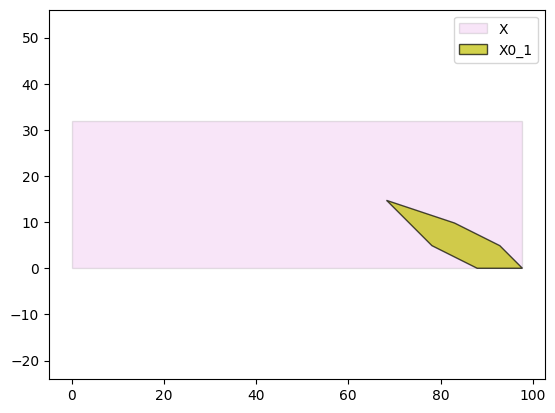

In [ ]:
C = {}
PreS = precursor(eps_box, A, U, B)
for k in range(N):
    C[k]= PreS.intersect(X)
    PreS = precursor(C[k], A, U, B)

X0_1 = C[N-1]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

X.plot(ax, color='m', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)      # state constraint set
X0_1.plot(ax, color='y', alpha=0.7, linestyle='solid', linewidth=1)       # initial feasible set
ax.legend(['X', 'X0_1'])

ax.autoscale_view()
ax.axis('equal')
plt.show()

Of course not feasible:

Terminal set Xf is a point not an invariant set, which does not satisfy the three assumptions that X0_1 is persistently feasible through the close-loop. So it could not ensure that: for all initial states in X0, the designed MPC is recursively feasible.



<font color='red'>D4:</font> Use $\bar{z}_{0}=[0,20]^{\top}$ and $d_{stop}=100$ m. Call the `sim_mpc()` function from (D1) with the given inputs `zbar0`=$\bar{z}_0$, `d_stop`=$d_{stop}$, $P = P_{∞}$, $N=3$.

Now set $X_f$ to be the maximal invariant set $O_\infty$ for the closed loop system $x(k+1) = (A+BF_\infty)x(k)$ subject to
the given constraints. Here $F_\infty$ is the infinite time LQR controller for the system $x(k+1) = Ax(k)+Bu(k)$ with weights $Q$ and $R$ defined previously, such that $u(k)=F_{\infty} x(k)$. Choose the terminal cost $P$ to be $P_{\infty}$ which is the infinite time cost associated with the controller $u(k)=F_{\infty}x(k)$. Write your code in the following format that formulates and solves the MPC problem. (Note: your code will be largely similar to your previous one, with the exception that you are now using different terminal constraints)

* Submit the results of the sim\_mpc() function for the given conditions, including a plot of open-loop predictions and closed-loop trajectories.
* Compute and plot the initial feasible set $X_0$ (N-step controllable set to $X_f$) along with $X$, which is the state constraint set.
* Is the MPC that you designed recursively feasible for all initial states in $X_0$ using the given settings and initial conditions for $M=100$? Explain why or why not (Stating that the MPC is feasible for n-steps or no longer feasible after k-steps is not an acceptable answer).


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


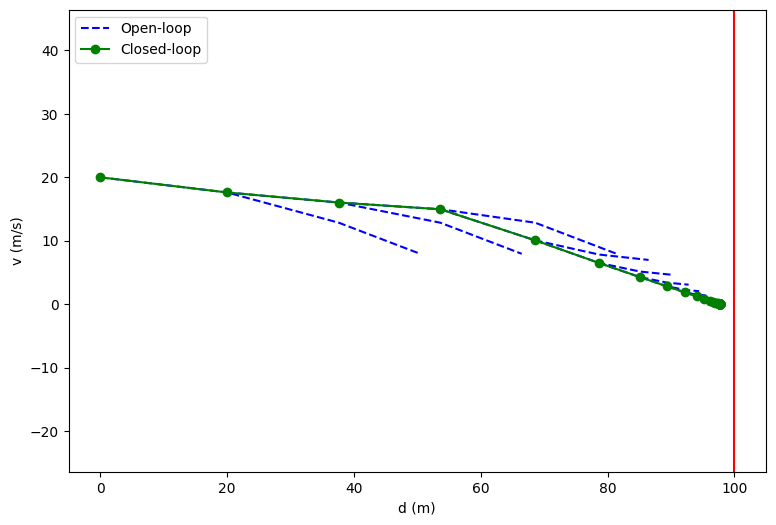

In [ ]:
A = np.array([[1, 1], [0, 1]])  # State transition matrix
B = np.array([[0], [1]])  # Control input matrix

def dlqr(A, B, Q, R):
    # solve Discrete Algebraic Riccatti equation
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)

    # compute the LQR gain
    K = -scipy.linalg.inv(B.T @ P @ B + R) @ (B.T @ P @ A)

    # stability check
    eigVals, eigVecs = scipy.linalg.eig(A + B @ K)
    return K, P, eigVals

F_inf, P_inf, eigvals = dlqr(A, B, Q, R)
A_cl = A + B@F_inf
S = X.intersect(pt.Polytope(U.A@F_inf, U.b))
O_inf = Oinf(S, A_cl)
Af = O_inf.A
bf = O_inf.b

_ = sim_mpc(zbar0,d_stop,3,Af,bf,P=P_inf)

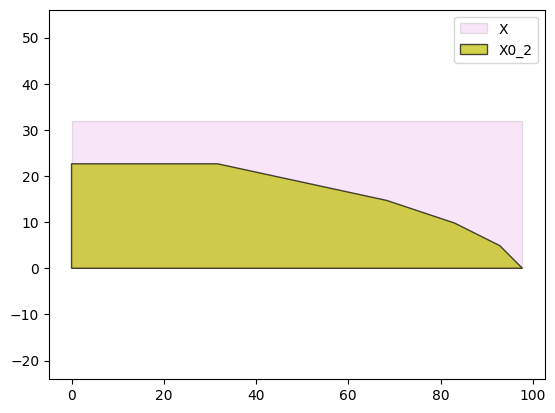

In [ ]:
C = {}
PreS = precursor(O_inf, A, U, B)
for k in range(N):
    C[k]= PreS.intersect(X)
    PreS = precursor(C[k], A, U, B)

X0_2 = C[N-1]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

X.plot(ax, color='m', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)      # state constraint set
X0_2.plot(ax, color='y', alpha=0.7, linestyle='solid', linewidth=1)       # initial feasible set
ax.legend(['X', 'X0_2'])

ax.autoscale_view()
ax.axis('equal')
plt.show()

Of course feasible:

1.Stage cost is positive define, which is known from Q and R

2.Terminal set O_inf is an invariant set

3.From the P, we can know that terminal cost is continous Lyapunov Function in the terminal set O_inf.

Under 3 assumption above, we can get the set of initial feasible X0_2 is also the set of initial states which are persistently feasible for the system in close-loop with designed MPC.

------

<font color='red'>D5:</font> Plot $X_0^1$, $X_0^2$,   $X$, and $C_{\infty}$ on the same figure, where $X_0^1$ is the initial feasible set from (D3), $X_0^2$ is the initial feasible set from (D4), $X$ is the state constraint set, and $C_{\infty}$ is the maximal control invariant set for the system $x(k+1) = Ax(k)+Bu(k)$ subject to the given constraints.

* Plot $X_0^1$, $X_0^2$, $X$, and $C_{\infty}$ on the same figure. Comment on how they compare in sizes and make statements on which design approach is "better" and why.`
* Let $X_{D2}$ be the initial feasible set of the MPC designed in D2. Is $X_{D2}$ an invariant set? If not, can you compute the $O_{\infty}$ set for the closed-loop system $x(k+1) = Ax(k)+Bu(k)$ where $u(k)$ is the MPC controller designed in (D2) subject to the given constraints? If easy, please compute, if not easy explain why.
* Using the same dynamic model, horizon length, sampling time, state/input constraints, can you design an MPC controller with $X_0=C_{\infty}$? If yes, explain how you would approach designing such an MPC controller and what the associated difficulties are.

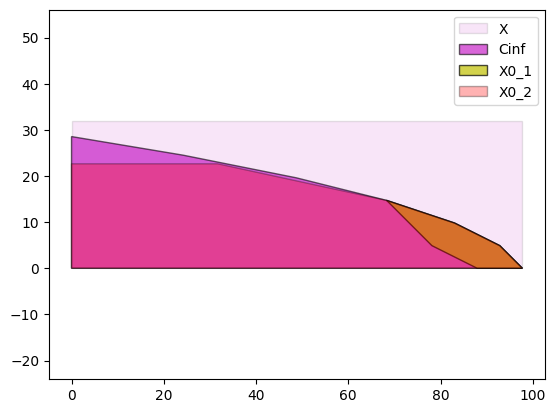

In [ ]:
def Cinf(A, B, Xset, Uset):

    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    return Omegap

C_inf = Cinf(A, B, X, U)

plt.clf()
plt.cla()
plt.close('all')
X
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

X.plot(ax, color='m', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)      # state constraint set
C_inf.plot(ax, color='m', alpha=0.6, linestyle='solid', linewidth=1)    # maximal control invariant set
X0_1.plot(ax, color='y', alpha=0.7, linestyle='solid', linewidth=1)
X0_2.plot(ax, color='r', alpha=0.3, linestyle='solid', linewidth=1)
ax.legend(['X', 'Cinf', 'X0_1', 'X0_2'])

ax.autoscale_view()
ax.axis('equal')
plt.show()

The sizes are listed in descending order: X, Cinf, X0_2, X0_1.

X0_2 is the better design approach with terminal set Xf is to be the maximal invariant set Oinf.

1.Because its feasible set X0_2 is bigger than X0_1, which has more relaxed requirements for choice of the initial states.

2.Because the control policy derived with terminal set is Oinf typically ensures closed-loop stability. When system enters the Oinf, it will inherently ensure stability in its design.

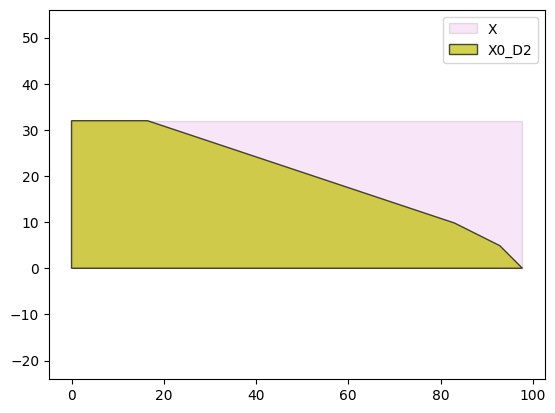

In [ ]:
C = {}
PreS = precursor(X, A, U, B)
for k in range(N):
    C[k]= PreS.intersect(X)
    PreS = precursor(C[k], A, U, B)
X0_D2 = C[N-1]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
X.plot(ax, color='m', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)      # state constraint set
X0_D2.plot(ax, color='y', alpha=0.7, linestyle='solid', linewidth=1)       # initial feasible set
ax.legend(['X', 'X0_D2'])
ax.autoscale_view()
ax.axis('equal')
plt.show()

The yellow part in the above figure is XD2, not an invariant set because A fraction of the points departing in XD2 must leave XD2.

Oinf is very difficult to compute:

1.Terminal sets are used to ensure the stability and recursive feasibility of a system. Without terminal sets, we cannot guarantee that the system will remain in a controllable state when it reaches the end of the prediction range, which means that the system may leave the controllable region and enter a state of uncertainty, making the computation of the O_inf difficult.

2.Without terminal set, the system will invest more time and computational resources to solve for different paths. After that,the optimization problem can become very complex because it requires keeping the state and control inputs of the system in the feasible domain throughout an infinite time horizon. This usually requires the consideration of more constraints and more complex decision variables, increasing the computational difficulty of the problem.


Yes, I can:

1.Use the iterative function C_inf = Cinf(A, B, X, U) to compute C_inf

2.Choose X0 = C_inf, use the function Reach(X0,U,A,B,N) to iteratively compute the Reachable Set after N steps and select it as the Terminal set Xf.

3.Pick the appropriate P such that the terminal cost is the Lyapunov function to ensure stablilty.

Difficulty:

1.Similar to computing the precursor set, computing the reachable set depends on the complexity of the dynamics of the system, the constraints of the state and control, and the granularity of the time discretization. In some cases, especially in control theory and optimization problems, the computation of reachable sets may require specialized software packages and numerical methods.

2.Insufficient real-time's application: MPC needs to solve the optimization problem quickly at each control step in order to update the control inputs in real-time.The huge amount of computation will make the control ineffective.